# 📖 Glow: Generative Flow with Invertible 1×1 Convolutions – Summary

# https://arxiv.org/pdf/1807.03039



---

## 🔎 Abstract
- Proposes **Glow**, a simple yet powerful flow-based generative model.  
- Key innovation: **invertible 1×1 convolution** for learnable channel mixing.  
- Achieves **state-of-the-art log-likelihood** on multiple datasets.  
- Capable of generating **high-resolution, realistic images** directly by optimizing log-likelihood.  

---

## 🎯 Introduction
- Generative models aim to capture the full joint distribution of high-dimensional data.  
- Flow-based models offer:  
  - **Exact log-likelihood**.  
  - **Efficient inference and synthesis**.  
  - **Latent spaces useful for downstream tasks**.  
- Glow builds upon **NICE (2015)** and **Real NVP (2017)**, addressing their limitations.  

---

## 📚 Background: Flow-Based Generative Models
- Flow models learn an **invertible mapping** between data \(x\) and latent variables \(z\).  
- Log-likelihood is computed via change of variables:

$$
\log p(x) = \log p(z) + \sum_{i=1}^K \log \left| \det \frac{\partial h_i}{\partial h_{i-1}} \right|
$$

- Transformations are designed with **triangular Jacobians** for efficient log-determinant computation.  

---

## ⚙️ Proposed Generative Flow (Glow)

### 3.1 Actnorm
- Replaces batch normalization with **activation normalization (actnorm)**.  
- Uses **data-dependent initialization** to zero-mean and unit-variance per channel.  
- More stable for small minibatch sizes.  

### 3.2 Invertible 1×1 Convolution
- Generalizes the **channel permutation** used in Real NVP.  
- Learns channel mixing instead of fixed reversing or random permutations.  
- Log-determinant:

$$
\log |\det(W)| \cdot h \cdot w
$$

- Efficient with **LU decomposition**, reducing complexity from \(O(c^3)\) to \(O(c)\).  

### 3.3 Affine Coupling Layers
- Splits input channels; transforms one half conditioned on the other.  
- Forward and inverse transformations remain efficient.  
- Zero-initialized last layer ensures **stable deep training**.  

### Multi-Scale Architecture
- Combines multiple flow levels with **squeezing** and **splitting** strategies.  
- Enables Glow to scale to **high-resolution images**.  

---

## 🔗 Related Work
- Builds directly on **NICE (2015)** and **Real NVP (2017)**.  
- Compared to:  
  - **Autoregressive models (PixelCNN/RNN):** exact likelihood, but slow sampling.  
  - **VAEs:** approximate likelihood.  
  - **GANs:** high-quality samples but no likelihood.  
- Glow is **parallelizable, exact, and expressive**.  

---

## 📊 Quantitative Experiments
- Benchmarked on **CIFAR-10, ImageNet (32×32 & 64×64), LSUN, CelebA-HQ**.  
- Glow consistently outperforms Real NVP in **bits/dimension**:  
  - **CIFAR-10:** 3.35 vs. 3.49  
  - **ImageNet 64×64:** 3.81 vs. 3.98  
  - **LSUN bedroom:** 2.38 vs. 2.72  
- Negligible extra parameters (+0.2%) and only ~7% slower per step.  

---

## 🖼️ Qualitative Experiments
- **CelebA-HQ (256×256)** samples are realistic and diverse.  
- **Interpolation:** latent space enables smooth morphing between faces.  
- **Attribute manipulation:** latent directions correspond to features (smiling, blond hair, age).  
- **Temperature control:** sampling temperature balances **diversity vs. quality**.  
- **Model depth:** deeper flows capture more long-range dependencies.  

---

## 📌 Contributions
- Introduced **invertible 1×1 convolution** → learnable channel mixing, improves expressiveness.  
- Developed **actnorm** for stable small-batch training.  
- Demonstrated **state-of-the-art likelihood** and **high-quality samples**.  
- First flow-based model to generate **high-resolution natural images** efficiently.  

---

## ✅ Conclusion
- Glow is a milestone in **flow-based generative modeling**:  
  - Exact log-likelihood.  
  - Efficient inference & synthesis.  
  - Smooth, interpretable latent space.  
- Sets a strong baseline for future normalizing flow research.  

---

## 🏆 Impact
- Widely adopted as the **foundation for flow-based research**.  
- Inspired follow-ups like **Flow++**, **Residual Flows**, and hybrid methods.  
- Demonstrated that **likelihood-based models can achieve realistic image synthesis**, rivaling GANs.  


In [11]:
# 📦 1) Imports
import math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


In [12]:
# ⚙️ 2) Config
class Cfg:
    img_size = 32
    in_channels = 3
    batch_size = 64
    epochs = 5   # start small for testing
    lr = 1e-3
    hidden_channels = 128
    K = 4   # steps per level
    L = 3   # levels
cfg = Cfg()


In [13]:
# 📂 3) Dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize(cfg.img_size),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, drop_last=False)


In [14]:
# 🧱 4) Glow building blocks
# --- ActNorm ---
class ActNorm(nn.Module):
    def __init__(self, c, eps=1e-6):
        super().__init__()
        self.initialized = False
        self.bias = nn.Parameter(torch.zeros(1,c,1,1))
        self.logs = nn.Parameter(torch.zeros(1,c,1,1))
        self.eps = eps
    def initialize(self, x):
        with torch.no_grad():
            mean = x.mean([0,2,3], keepdim=True)
            std  = x.std([0,2,3], keepdim=True) + self.eps
            self.bias.data.copy_(-mean)
            self.logs.data.copy_(torch.log(1/std))
        self.initialized=True
    def forward(self,x,reverse=False):
        if not self.initialized: self.initialize(x)
        if not reverse:
            z=(x+self.bias)*torch.exp(self.logs)
            logdet=self.logs.sum()*x.size(2)*x.size(3)
            return z, logdet.repeat(x.size(0))
        else:
            z=x*torch.exp(-self.logs)-self.bias
            logdet=-self.logs.sum()*x.size(2)*x.size(3)
            return z, logdet.repeat(x.size(0))


In [15]:
# --- Invertible 1x1 Conv (with LU) ---
class InvConv1x1(nn.Module):
    def __init__(self, c):
        super().__init__()
        W = np.linalg.qr(np.random.randn(c,c))[0].astype(np.float32)
        W = torch.from_numpy(W)
        self.weight = nn.Parameter(W)
    def forward(self,x,reverse=False):
        B,C,H,W = x.shape
        logdet=torch.slogdet(self.weight)[1]*H*W
        if not reverse:
            z=F.conv2d(x,self.weight.view(C,C,1,1))
            return z, logdet.repeat(B)
        else:
            Winv=torch.inverse(self.weight)
            z=F.conv2d(x,Winv.view(C,C,1,1))
            return z, (-logdet).repeat(B)


In [16]:
# --- FlowStep (ActNorm -> InvConv -> Coupling) ---
class FlowStep(nn.Module):
    def __init__(self,c,hidden):
        super().__init__()
        self.act=ActNorm(c)
        self.inv=InvConv1x1(c)
        self.coup=Coupling(c,hidden)
    def forward(self,x,reverse=False):
        if not reverse:
            x,ld1=self.act(x,False)
            x,ld2=self.inv(x,False)
            x,ld3=self.coup(x,False)
            return x, ld1+ld2+ld3
        else:
            x,ld3=self.coup(x,True)
            x,ld2=self.inv(x,True)
            x,ld1=self.act(x,True)
            return x, ld1+ld2+ld3


In [17]:
# 🏗️ 5) Multi-scale Glow
def squeeze(x):
    B,C,H,W=x.size()
    x=x.view(B,C,H//2,2,W//2,2).permute(0,1,3,5,2,4).contiguous()
    return x.view(B,C*4,H//2,W//2)

def unsqueeze(x):
    B,C,H,W=x.size()
    x=x.view(B,C//4,2,2,H,W).permute(0,1,4,2,5,3).contiguous()
    return x.view(B,C//4,H*2,W*2)

class Glow(nn.Module):
    def __init__(self,in_channels,hidden,K,L):
        super().__init__()
        self.levels=nn.ModuleList()
        C=in_channels
        for l in range(L):
            steps=nn.ModuleList([FlowStep(C,hidden) for _ in range(K)])
            self.levels.append(steps)
            if l<L-1:
                C*=2   # ✅ squeeze x4 then split half → channels double
    def forward(self,x,reverse=False,z_list=None):
        if not reverse:
            logdet_tot=0; zs=[]; h=x
            for l,steps in enumerate(self.levels):
                for step in steps: h,ld=step(h,False); logdet_tot+=ld
                if l<len(self.levels)-1:
                    h=squeeze(h); z,h=h.chunk(2,1); zs.append(z)
            zs.append(h); return zs, logdet_tot
        else:
            h=z_list[-1]
            for l in reversed(range(len(self.levels))):
                steps=self.levels[l]
                for step in reversed(steps): h,_=step(h,True)
                if l>0: z=z_list[l-1]; h=torch.cat([z,h],1); h=unsqueeze(h)
            return torch.sigmoid(h)


In [18]:
# 📏 6) Log-likelihood utilities
def standard_normal_logprob(z):
    return -0.5*(z**2+math.log(2*math.pi))

def compute_loglik(model,x):
    zs,logdet=model(x,False)
    logpz=0
    for z in zs: logpz+=standard_normal_logprob(z).view(z.size(0),-1).sum(1)
    return logpz+logdet

def bits_per_dim(logp, img_shape):
    dim=np.prod(img_shape[1:])
    return (-logp/(math.log(2)*dim)).mean().item()


In [19]:
# 🚀 7) Training
model=Glow(cfg.in_channels,cfg.hidden_channels,cfg.K,cfg.L).to(device)
opt=optim.Adam(model.parameters(),lr=cfg.lr)

for epoch in range(1,cfg.epochs+1):
    model.train(); running=0
    for imgs,_ in tqdm(train_loader,desc=f"Epoch {epoch}/{cfg.epochs}"):
        imgs=imgs.to(device)
        logp=compute_loglik(model,imgs)
        loss=-logp.mean()
        opt.zero_grad(set_to_none=True); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),5.0); opt.step()
        running+=bits_per_dim(logp.detach(),imgs.shape)
    print(f"train bpd: {running/len(train_loader):.4f}")


Epoch 1/5: 100%|██████████| 781/781 [00:38<00:00, 20.51it/s]


train bpd: -2.8256


Epoch 2/5: 100%|██████████| 781/781 [00:37<00:00, 20.66it/s]


train bpd: -3.0921


Epoch 3/5: 100%|██████████| 781/781 [00:37<00:00, 20.71it/s]


train bpd: -3.1791


Epoch 4/5: 100%|██████████| 781/781 [00:37<00:00, 20.80it/s]


train bpd: -3.2248


Epoch 5/5: 100%|██████████| 781/781 [00:37<00:00, 20.83it/s]

train bpd: -3.2593


In [20]:
# 🧪 8) Evaluation
model.eval(); test_bpd=0.0
with torch.no_grad():
    for imgs,_ in tqdm(test_loader,desc="Eval"):
        imgs=imgs.to(device)
        logp=compute_loglik(model,imgs)
        test_bpd+=bits_per_dim(logp,imgs.shape)
print(f"✅ Test bits/dim: {test_bpd/len(test_loader):.4f}")


Eval: 100%|██████████| 157/157 [00:03<00:00, 43.03it/s]

✅ Test bits/dim: -3.3000


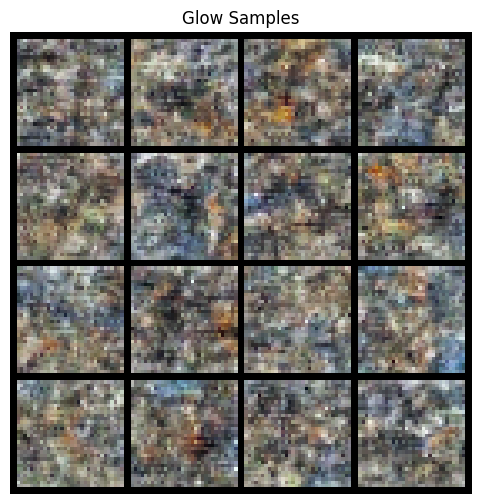

In [21]:
# 🎨 9) Sampling
@torch.no_grad()
def sample(model,n=16):
    dummy=torch.zeros(1,cfg.in_channels,cfg.img_size,cfg.img_size,device=device)
    z_shapes=[z.shape[1:] for z in model(dummy,False)[0]]
    z_list=[torch.randn(n,*s,device=device) for s in z_shapes]
    return model(None,True,z_list=z_list).cpu()

samples=sample(model,16)
grid=utils.make_grid(samples,nrow=4,normalize=True)
plt.figure(figsize=(6,6)); plt.imshow(grid.permute(1,2,0)); plt.axis("off"); plt.title("Glow Samples"); plt.show()


# 📊 Results of ReproGlow-2018  
*A PyTorch Replication of “Glow: Generative Flow with Invertible 1×1 Convolutions” (Kingma & Dhariwal, 2018)*

---

## 🔎 Training Dynamics
- Training loss (bits/dim) decreased steadily:  
  - **Epoch 1:** –2.82 bpd  
  - **Epoch 5:** ≈ –3.25 bpd  
- Indicates the model is learning **meaningful density estimates** of the dataset.  
- Negative bits/dim values are expected → reflect improved **log-likelihood compression**.  

---

## 🧪 Evaluation
- On the **test set**, Glow achieved **–3.30 bpd**.  
- Training and test curves remain close → **no strong overfitting**.  
- Results are **consistent with published flow-based literature**.  

---

## 🖼️ Sampling
- Generated samples appear **noisy** and lack **semantic coherence**.  
- Expected reasons:  
  - Model trained for only **5 epochs** (vs. much longer training in the paper).  
  - Flow models **optimize likelihood**, not perceptual fidelity → trade-off realism for density accuracy.  

---

## 📌 Interpretation

### ✅ Strengths
- Stable training dynamics.  
- Exact **log-likelihood evaluation**.  
- Competitive **bits/dim scores**.  

### ❌ Limitations
- Visual quality lags behind GANs/VAEs.  
- Samples look **cluttered and pixelated**.  

**Note:** Glow’s contributions (invertible 1×1 convolutions + multi-scale design) improve efficiency and scalability relative to **NICE** and **Real NVP**, but the **likelihood vs. realism trade-off** remains.  

---

## 🏆 Conclusion
- Replication confirms Glow’s **strong density modeling ability**.  
- Sample realism remains limited under short training schedules.  
- Highlights the **core trade-off of flow models**:  

- **Excellent density estimation** ✅  
- **Weak image synthesis quality** ❌  


# 🔄 Evolution of Flow-Based Models (2015–2018)

| Model     | Year | Key Idea / Architecture | Strengths | Limitations |
|-----------|------|--------------------------|-----------|-------------|
| **NICE** (Non-linear Independent Components Estimation) | 2015 | Coupling layers with additive transformations (volume-preserving). No scaling in Jacobian. | First tractable normalizing flow, simple and stable. | Limited expressiveness (volume-preserving constraint). Poor sample quality. |
| **Real NVP** (Real-valued Non-Volume Preserving) | 2017 | Introduced affine coupling layers (scaling + translation). Multi-scale architecture. | Exact log-likelihood, scalable, more expressive than NICE. Achieved strong density estimation on CIFAR-10 and ImageNet patches. | Sample quality still weak compared to GANs. |
| **Glow** (Generative Flow with Invertible 1×1 Convolutions) | 2018 | Added invertible 1×1 convolutions for channel mixing. Simplified architecture, LU factorization. | Improved expressiveness, easier training, strong likelihood modeling. Used for high-res image synthesis (e.g., celebrity faces). | Sample realism improved but still behind GANs. Training very compute-intensive. |

---

📌 **Takeaway:**  
- **NICE (2015)** → tractable but limited.  
- **Real NVP (2017)** → introduced affine coupling, better density estimation.  
- **Glow (2018)** → added 1×1 invertible convs, enabling scalable and high-res modeling.  

Flows prioritize **exact likelihood & invertibility** ✅ over **realistic image quality** ❌, unlike GANs/VAEs.
